<a href="https://colab.research.google.com/github/aditya2k5/Forecasting-electric-load-using_ML/blob/main/Loadprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


📊 DATA LOADING AND PREPROCESSING
✅ Dataset loaded
Shape: (52416, 7)
Features: ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'DayOfWeek', 'Month']
Target: PowerConsumption

🔧 DATA STANDARDIZATION
Train shape: (41932, 8), Test shape: (10484, 8)

🔧 TRAINING MODELS

🎛️ SVR HYPERPARAMETER TUNING (FAST)
Best SVR params: {'kernel': 'linear', 'gamma': 'scale', 'C': 10}
Best SVR MAE (neg): -3636.761127716783

🎛️ RANDOM FOREST OPTIMIZATION
Best parameters: {'n_estimators': 30, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.5, 'max_depth': 15}
Best CV score: 0.9625


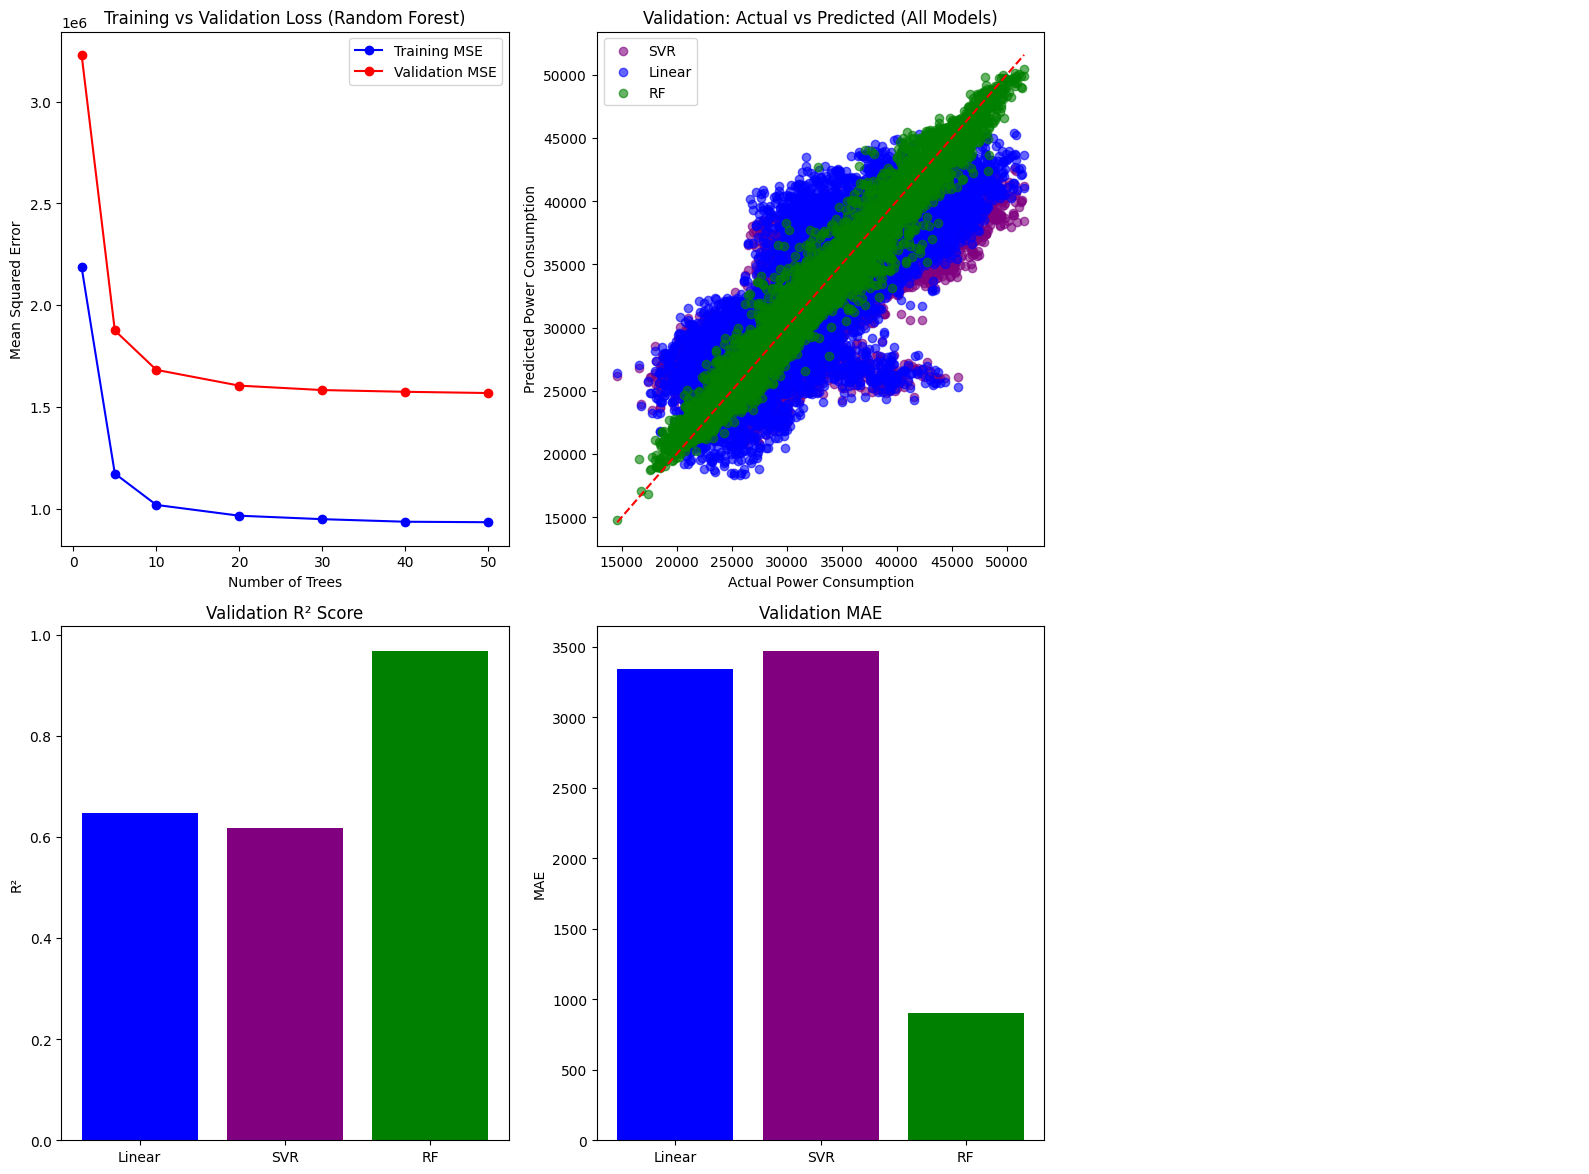


=== Model Performance Metrics Table ===
               Model  R2 Score          MAE
0  Linear Regression  0.648309  3345.140537
1                SVR  0.617154  3473.582561
2      Random Forest  0.968656   904.719331


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
import warnings
warnings.filterwarnings('ignore')

def load_and_preprocess_data():

    df = pd.read_csv("loadpredictiondataset.csv")

    print(f"Shape: {df.shape}")
    if 'Datetime' in df.columns:
        df['Datetime'] = pd.to_datetime(df['Datetime'])
        df['Hour'] = df['Datetime'].dt.hour
        df['DayOfWeek'] = df['Datetime'].dt.dayofweek
        df['Month'] = df['Datetime'].dt.month
    df = df.fillna(df.median(numeric_only=True))
    feature_cols = [col for col in df.columns if col not in ['Datetime', 'PowerConsumption']]
    X = df[feature_cols]
    y = df['PowerConsumption']
    print(f"Features: {feature_cols}")
    print(f"Target: PowerConsumption")
    return X, y, feature_cols

def standardize_data(X, y):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print(f"Train shape: {X_train_scaled.shape}, Test shape: {X_test_scaled.shape}")
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

def optimize_random_forest(X_train_scaled, y_train):

    param_grid = {
        'n_estimators': [20, 30, 50],
        'max_depth': [8, 10, 15],
        'min_samples_split': [3, 5, 8],
        'min_samples_leaf': [2, 3, 4],
        'max_features': ['sqrt', 'log2', 0.5]
    }
    rf_base = RandomForestRegressor(random_state=42, n_jobs=1)
    random_search = RandomizedSearchCV(estimator=rf_base, param_distributions=param_grid,
                                       n_iter=10, cv=3, scoring='r2', n_jobs=1, random_state=42)
    random_search.fit(X_train_scaled, y_train)
    model = random_search.best_estimator_
    print("Best parameters:", random_search.best_params_)
    print("Best CV score:", f"{random_search.best_score_:.4f}")
    return model

def optimize_svr(X_train_scaled, y_train):

    param_dist = {
        'kernel': ['rbf', 'linear'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 0.1, 1]
    }
    svr = SVR()
    if len(X_train_scaled) > 2000:
        idx = np.random.choice(len(X_train_scaled), 2000, replace=False)
        X_subset = X_train_scaled[idx]
        y_subset = np.array(y_train)[idx]
    else:
        X_subset = X_train_scaled
        y_subset = y_train
    random_search = RandomizedSearchCV(svr, param_dist, n_iter=8,
                                       scoring='neg_mean_absolute_error',
                                       n_jobs=-1, cv=3, random_state=42)
    random_search.fit(X_subset, y_subset)
    print("Best SVR params:", random_search.best_params_)
    print("Best SVR MAE (neg):", random_search.best_score_)
    return random_search.best_estimator_

def train_and_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test):

    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    y_pred_lr = lr.predict(X_test_scaled)

    svr = optimize_svr(X_train_scaled, y_train)
    y_pred_svr = svr.predict(X_test_scaled)

    rf = optimize_random_forest(X_train_scaled, y_train)
    y_pred_rf = rf.predict(X_test_scaled)

    return (lr, y_pred_lr), (svr, y_pred_svr), (rf, y_pred_rf)

def plot_eval_updated(X_train_scaled, X_test_scaled, y_train, y_test,
                      y_pred_lr, y_pred_svr, y_pred_rf, rf_model):

    n_estimators_seq = [1, 5, 10, 20, 30, 40, 50]
    train_loss, val_loss = [], []
    for n_trees in n_estimators_seq:
        model = RandomForestRegressor(
            n_estimators=n_trees,
            max_depth=rf_model.get_params().get("max_depth"),
            min_samples_split=rf_model.get_params().get("min_samples_split"),
            min_samples_leaf=rf_model.get_params().get("min_samples_leaf"),
            max_features=rf_model.get_params().get("max_features"),
            random_state=42,
            n_jobs=1
        )
        model.fit(X_train_scaled, y_train)
        train_pred = model.predict(X_train_scaled)
        val_pred = model.predict(X_test_scaled)
        train_loss.append(mean_squared_error(y_train, train_pred))
        val_loss.append(mean_squared_error(y_test, val_pred))


    plt.figure(figsize=(16, 12))


    plt.subplot(2, 3, 1)
    plt.plot(n_estimators_seq, train_loss, 'o-', color='blue', label='Training MSE')
    plt.plot(n_estimators_seq, val_loss, 'o-', color='red', label='Validation MSE')
    plt.xlabel('Number of Trees')
    plt.ylabel('Mean Squared Error')
    plt.title('Training vs Validation Loss (Random Forest)')
    plt.legend()


    plt.subplot(2, 3, 2)
    r2_scores = {
        "Linear": r2_score(y_test, y_pred_lr),
        "SVR": r2_score(y_test, y_pred_svr),
        "RF": r2_score(y_test, y_pred_rf)
    }
    sorted_models = sorted(r2_scores.items(), key=lambda x: x[1])
    color_map = {"Linear": "blue", "SVR": "purple", "RF": "green"}
    for model_name, _ in sorted_models:
        y_pred = {'Linear': y_pred_lr, 'SVR': y_pred_svr, 'RF': y_pred_rf}[model_name]
        plt.scatter(y_test, y_pred, alpha=0.6, label=model_name, color=color_map[model_name])
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Power Consumption')
    plt.ylabel('Predicted Power Consumption')
    plt.title('Validation: Actual vs Predicted (All Models)')
    plt.legend()


    plt.subplot(2, 3, 4)
    plt.bar(list(r2_scores.keys()), list(r2_scores.values()), color=[color_map[m] for m in r2_scores.keys()])
    plt.title("Validation R² Score")
    plt.ylabel("R²")


    mae_scores = {
        "Linear": mean_absolute_error(y_test, y_pred_lr),
        "SVR": mean_absolute_error(y_test, y_pred_svr),
        "RF": mean_absolute_error(y_test, y_pred_rf)
    }
    plt.subplot(2, 3, 5)
    plt.bar(list(mae_scores.keys()), list(mae_scores.values()), color=[color_map[m] for m in mae_scores.keys()])
    plt.title("Validation MAE")
    plt.ylabel("MAE")


    plt.subplot(2, 3, 6)
    plt.axis('off')


    plt.tight_layout()
    plt.show()

    # Print metrics in tabular form
    metrics_df = pd.DataFrame({
        'Model': ['Linear Regression', 'SVR', 'Random Forest'],
        'R2 Score': list(r2_scores.values()),
        'MAE': list(mae_scores.values())
    })
    print("\n=== Model Performance Metrics Table ===")
    print(metrics_df)

def main():
    X, y, feature_cols = load_and_preprocess_data()
    X_train_scaled, X_test_scaled, y_train, y_test, scaler = standardize_data(X, y)

    (lr_model, y_pred_lr), (svr_model, y_pred_svr), (rf_model, y_pred_rf) = train_and_evaluate_models(
        X_train_scaled, X_test_scaled, y_train, y_test)

    plot_eval_updated(
        X_train_scaled, X_test_scaled, y_train, y_test,
        y_pred_lr, y_pred_svr, y_pred_rf, rf_model)


if __name__ == "__main__":
    main()